In [0]:
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

# 【問題1】K-meansクラスの作成
- クラスタのラベリング→
- TODO:全体的にもっと綺麗にかけそう

In [0]:
import numpy as np

class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    num_iter : int
        イテレーション数
    n_clusters
        クラスタ数
    n_init
        k-meansを行う回数
        
    Attributes
    ----------
    cluster_centers_
        クラスタの中心の値を格納した配列
    """

    
    def __init__(self, num_iter=200, n_clusters=8, n_init=10, tol=1e-5):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        # クラスタ数
        self.n_clusters = n_clusters
        # k-meansを行う回数
        self.n_init = n_init
        # 誤差の許容値
        self.tol = tol
        # Xのデータ格納用
        self.X_n_features = None
        self.X_n_samples = None
        # クラスタの中心値格納用
        self.cluster_centers_ = None
        # 各Xのラベル格納用
        self.labels_ = None
        # sse格納用
        self.inertia_ = None
        

    def fit(self, X):
        """
        kmeansを学習する。
        
          Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        
        # 次元数を必要に応じて追加
        if X.ndim < 2:
            X = X[:, np.newaxis]
        
        # Xの情報をインスタンス変数へ
        self.X_n_samples = X.shape[0]
        self.X_n_features = X.shape[1]
        
        for i in range(self.n_init):
            # 設定されたクラスタ数に応じて、座標の初期化
            cluster_centers = X[np.random.choice(self.X_n_samples, self.n_clusters, replace=False), :]
            # 前ラベル格納用
            ex_labels = np.zeros(self.X_n_samples)
            
            for j in range(self.iter):
                # クラスタを作成するためにラベリング
                labels = self._label_by_euclidean_distance(X, cluster_centers)
                
                # ラベルに応じてクラスタを作成し、重心を求める
                gravities = self._calc_gravities(X, labels)
                
                # 中心点と重心の差が指定した許容値以下になるorラベルが変化しなくなるまで中心点を更新
                if  np.abs(np.sum(gravities - cluster_centers)) > self.tol or np.allclose(labels, ex_labels):
                    cluster_centers = gravities
                    ex_labels = labels
                else:
                    break
                
            # 目的関数コール
            sse = SSE(X, cluster_centers, labels)
            
            # ループ初回orSSEが低かったら、クラスタの中心を更新
            if i == 0 or self.inertia_ > sse:
                self.cluster_centers_ = cluster_centers
                self.inertia_ = sse
                self.labels_ = labels
                
            
    def _label_by_euclidean_distance(self, X, cluster_centers):
        """
        ユークリッド距離の計算結果に基づいて、ラベリングする
            
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        cluster_centers: 次の形のndarray, shape (n_clusters, n_features)
            クラスタの中心値
            
        Returns
        -------
        label : 次の形のndarray, shape (n_samples,)
            クラスタのラベル
        """

        #  距離データ格納用
        e_distances = np.empty((0, self.X_n_samples), int)
        
        for i in range(self.n_clusters):
            # 距離を計算し配列に格納
            e_distance = np.linalg.norm(X - cluster_centers[i], axis=1)
            e_distances = np.append(e_distances, np.array([e_distance]), axis=0)
        
        # 配列のうち最小値となる特徴量のラベルを取得
        labels = np.argmin(e_distances, axis=0)
        
        # クラスタ数とラベリングの種類数がイコールでない場合
        if self.n_clusters != len(np.unique(labels)):
            # ラベリングできていないクラスタを調べる
            n_clusters_ary = np.arange(self.n_clusters)
            missing_cluster = np.delete(n_clusters_ary, np.unique(labels))[0]
            
            # ラベリングできなかったクラスタの中心点からもっとも遠いXの行indexを調べる
            e_distance = np.argmax(np.linalg.norm(X - skm.cluster_centers_[missing_cluster], axis=1))
            
            # もっとも遠いXに対応する行のラベルをラベリングできていないクラスタのラベルに変更
            labels[e_distance] = missing_cluster
            
        return labels


    def _calc_gravities(self, X, label):
        """
       ラベルを元にクラスタの重心を求める

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        label : 次の形のndarray, shape (n_samples,)
            クラスタのラベル
            
        Returns
        -------
        gravities: 次の形のndarray, shape (n_clusters, n_features)
            クラスタの重心
        """
        
        # 重心格納用配列初期化
        gravities = np.zeros((self.n_clusters, self.X_n_features))
                               
        for i in range(self.n_clusters):
            # 各クラスタを作成
            cluster = X[np.where(label == i)[0], :]
            
            # クラスタの重心を計算し配列に格納
            gravities[i] = np.sum(cluster, axis=0) / len(cluster)
            
        return gravities
        
        
    def predict(self, X):
        """
        kmeansを使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            kmeansによる推定結果
        """
        
        y_pred = self._label_by_euclidean_distance(X, self.cluster_centers_)
        
        return y_pred

In [0]:
import numpy as np

def SSE(X, cluster_centers, labels):
    sse = 0
    for label in np.unique(labels):
        cluster_index = np.where(labels == label)[0]
        sse += np.linalg.norm(X[cluster_index, :] - cluster_centers[label]) ** 2
        
    return sse
    

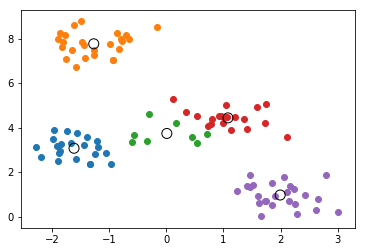

In [0]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

n_clusters = 5
n_init=40

skm = ScratchKMeans(n_clusters=n_clusters, n_init=n_init)
skm.fit(X)

y_pred = skm.predict(X)

# 各要素をラベルごとに色付けして表示する
for i in range(n_clusters):
    labels = X[y_pred == i]
    plt.scatter(labels[:, 0], labels[:, 1])
    
centers = skm.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100,
            facecolors='none', edgecolors='black')

やりたいことはできてそう 中心値の初期化は40回ぐらいを指定するとクラスタりんぐが安定した
# 【問題2】エルボー法の実装

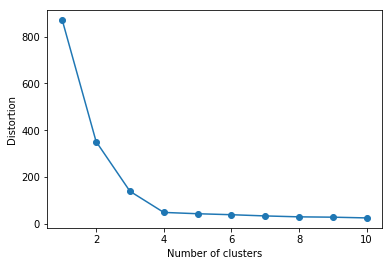

In [0]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    skm = ScratchKMeans(n_clusters=i)      # スクラッチ
    skm.fit(X)
    distortions.append(skm.inertia_)   # skm.fitするとskm.inertia_が得られる

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

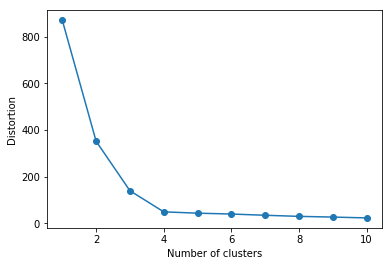

In [0]:
km = KMeans(n_clusters=5)    # sklearn

y_km = km.fit_predict(X)
 
distortions = []
 
for i  in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

大丈夫そう
# 【問題3】（アドバンス課題）シルエット図

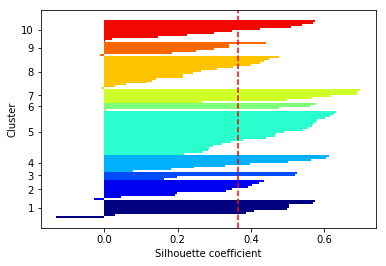

In [0]:
# shape(n_samples,)のndarray、各データ点のクラスタラベル名
y_km = skm.labels_
# list、クラスタのラベル名のリスト
cluster_labels = np.unique(y_km)
# int、クラスタ数
n_clusters=cluster_labels.shape[0]
# shape(n_samples,)のndarray、各データ点のシルエット係数
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

# float、シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

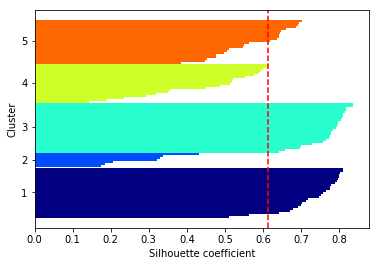

In [0]:
km = KMeans(n_clusters=5, n_init=40)    # sklearn

y_km = km.fit_predict(X)

# list、クラスタのラベル名のリスト
cluster_labels = np.unique(y_km)
# int、クラスタ数
n_clusters=cluster_labels.shape[0]
# shape(n_samples,)のndarray、各データ点のシルエット係数
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

# float、シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()


やりたいことはできてそう？   
<br>
### 卸売業者のデータ分析
### 次元削減

In [0]:
data = pd.read_csv('./input/Wholesale customers data.csv')

# ドロップ
data = data.drop(columns=['Region', 'Channel'])

data = np.log(data)

data.head()



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


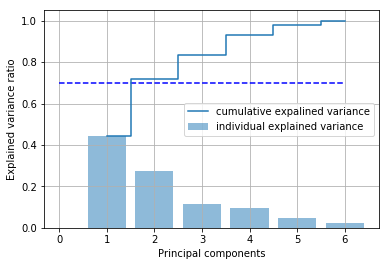

In [0]:
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [0]:
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
print(data_pca[:5])

[[-1.75098532 -0.07051523]
 [-1.80036534 -0.86975357]
 [-1.89373597 -1.67662072]
 [ 1.12731297 -1.45798229]
 [-0.79671147 -2.46086569]]


# 【問題4】クラスタ数kの選択
- エルボー法

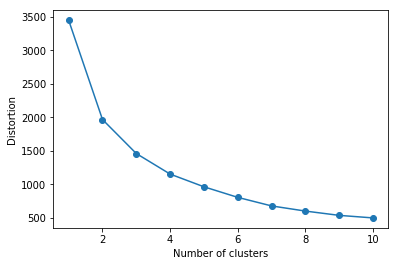

In [0]:
km = KMeans()

y_km = km.fit_predict(data_pca)
 
distortions = []
 
for i  in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(data_pca)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

エルボー法ではsseの値がガクッと下がる点を採用するらしい  
上記からは読み取りづらいが、
- 2の時が一番ガクッと下がってる
- 顧客をhigh・lowで分けてみたい  

ので、k=2を仮に採用してみる  
<br>
- シルエット図

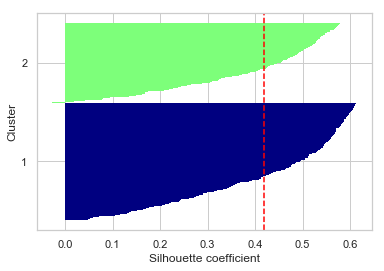

In [0]:
km = KMeans(n_clusters=2)

y_km = km.fit_predict(data_pca)

# list、クラスタのラベル名のリスト
cluster_labels = np.unique(y_km)
# int、クラスタ数
n_clusters=cluster_labels.shape[0]
# shape(n_samples,)のndarray、各データ点のシルエット係数
silhouette_vals = silhouette_samples(data_pca,y_km,metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

# float、シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()


シルエット図では、
- Clusterの厚さ
- Slilhouette coefficient が1に近いか
に着目するらしい  
k=2の場合は1のクラスターに偏ってるものの、ある程度はいい感じにクラスター分離できてそう

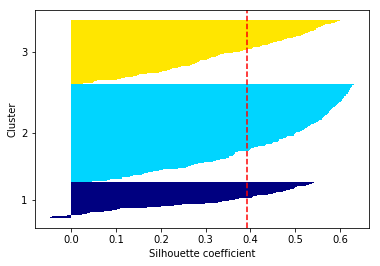

In [0]:
km = KMeans(n_clusters=3)

y_km = km.fit_predict(data_pca)

# list、クラスタのラベル名のリスト
cluster_labels = np.unique(y_km)
# int、クラスタ数
n_clusters=cluster_labels.shape[0]
# shape(n_samples,)のndarray、各データ点のシルエット係数
silhouette_vals = silhouette_samples(data_pca,y_km,metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

# float、シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()


k=3にしてみるとかなり厚さがまばらだったので、まだk=2がマシそう
<br>
結論として、k=2が最適だと考えた。  
理由は下記  
- エルボー法でガクッと落ちている地点であること
- クラスタ分離がそれなりにできてそう、かつシルエット係数が高い
- high/lowで分けることで後に扱いやすそう
<br>
<br>

# 【問題5】既知のグループとの比較

In [0]:
data = pd.read_csv('./input/Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


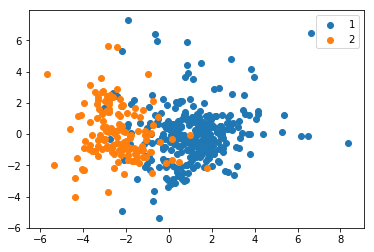

In [0]:
# Channel
channel = data['Channel']

for i in np.unique(channel):
    labels = data_pca[channel == i]
    plt.scatter(labels[:, 0], labels[:, 1], label=i)

plt.legend()
plt.show()

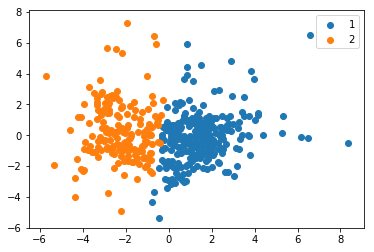

In [0]:
# clustering
km = KMeans(n_clusters=2)
y_km = km.fit_predict(data_pca)

# list、クラスタのラベル名のリスト
cluster_labels = np.unique(y_km)

for i in np.unique(cluster_labels):
    labels = data_pca[y_km == i]
    plt.scatter(labels[:, 0], labels[:, 1], label=i+1)
    
plt.legend()
plt.show()

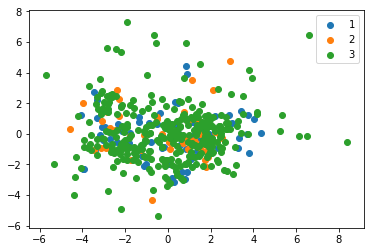

In [0]:
# Region
region = data['Region']

for i in np.unique(region):
    labels = data_pca[region == i]
    plt.scatter(labels[:, 0], labels[:, 1], label=i)
    
plt.legend()
plt.show()

金額ベースのデータをPCAしてクラスタリングしたところ、Channelに近く、Regionと異なる散らばりになった。


# 【問題6】卸売業者にとって有益な情報
まずはgroupbyを試してみる 既知グループのRegionを可視化

In [0]:
data.groupby('Region').describe()

Channel                                              Delicassen  \
         count      mean       std  min  25%  50%  75%  max      count   
Region                                                                   
1         77.0  1.233766  0.426000  1.0  1.0  1.0  1.0  2.0       77.0   
2         47.0  1.404255  0.496053  1.0  1.0  1.0  2.0  2.0       47.0   
3        316.0  1.332278  0.471777  1.0  1.0  1.0  2.0  2.0      316.0   

                      ...      Grocery            Milk               \
               mean   ...          75%      max  count         mean   
Region                ...                                             
1       1354.896104   ...      9490.00  39694.0   77.0  5486.415584   
2       1159.702128   ...     11758.50  67298.0   47.0  5088.170213   
3       1620.601266   ...     10559.75  92780.0  316.0  5977.085443   

                                                              
                std    min     25%     50%      75%      max  
Region                                                        
1       5704.856079  258.0  1372.0  3748.0  7503.00  28326.0  
2       5826.343145  333.0  1430.5  2374.0  5772.50  25071.0  
3       7935.463443   55.0  1634.0  3684.5  7198.75  73498.0  

[3 rows x 56 columns]

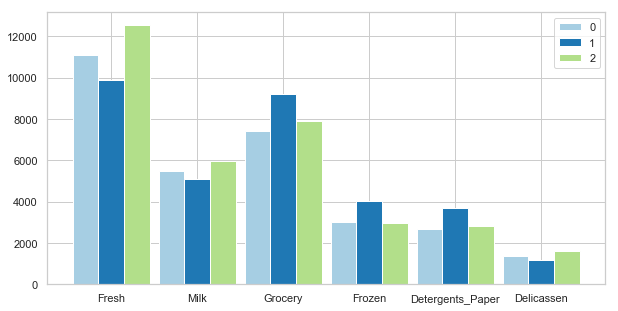

In [0]:
re = data.drop(columns='Channel')


sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = re.groupby(['Region']).mean().columns.values
x_position = np.arange(len(x))

re1 = re.groupby(['Region']).mean().values[0]
re2 = re.groupby(['Region']).mean().values[1]
re3 = re.groupby(['Region']).mean().values[2]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, re1, width=0.3, label=0)
ax.bar(x_position + 0.3, re2, width=0.3, label=1)
ax.bar(x_position + 0.6, re3, width=0.3, label=2)
ax.legend()
ax.set_xticks(x_position + 0.3)
ax.set_xticklabels(x)
plt.show()

散布図でもそうだったが、Regionをgroupbyしただけでは各特徴量間で目立った特徴は見られない  
次にChannel

In [0]:
data.groupby('Channel').describe()

Delicassen                                                         \
             count         mean          std  min     25%     50%     75%   
Channel                                                                     
1            298.0  1415.956376  3147.426922  3.0  379.00   821.0  1548.0   
2            142.0  1753.436620  1953.797047  3.0  566.75  1350.0  2156.0   

                 Detergents_Paper              ...       Milk          Region  \
             max            count         mean ...        75%      max  count   
Channel                                        ...                              
1        47943.0            298.0   790.560403 ...    4029.50  43950.0  298.0   
2        16523.0            142.0  7269.507042 ...   12162.75  73498.0  142.0   

                                                      
             mean       std  min  25%  50%  75%  max  
Channel                                               
1        2.510067  0.805013  1.0  2.0  3.0  3.0  3.0  
2        2.612676  0.703069  1.0  2.0  3.0  3.0  3.0  

[2 rows x 56 columns]

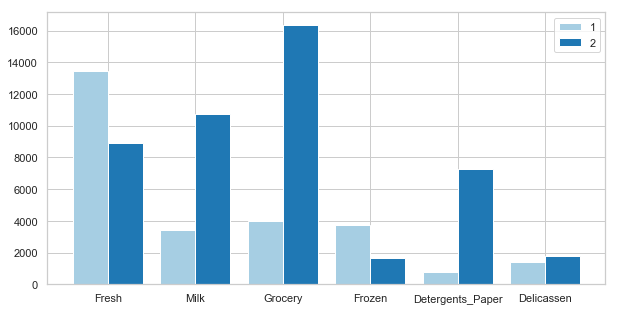

In [0]:
ch = data.drop(columns='Region')


sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = ch.groupby(['Channel']).mean().columns.values
x_position = np.arange(len(x))

ch1 = ch.groupby(['Channel']).mean().values[0]
ch2 = ch.groupby(['Channel']).mean().values[1]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, ch1, width=0.4, label=1)
ax.bar(x_position + 0.4, ch2, width=0.4, label=2)
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(x)
plt.show()

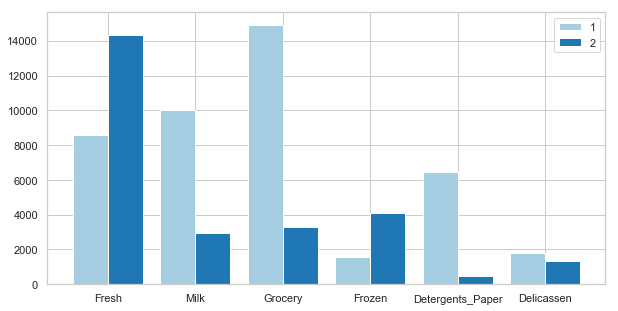

In [0]:
# clustering
km = KMeans(n_clusters=2)
y_km = km.fit_predict(data_pca)

cl = data.drop(columns=['Channel', 'Region'])

x = cl.columns.values
x_position = np.arange(len(x))

cl1 = cl[y_km == 0].mean().values
cl2 = cl[y_km == 1].mean().values

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, cl1, width=0.4, label=1)
ax.bar(x_position + 0.4, cl2, width=0.4, label=2)
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(x)
plt.show()

こちらも散布図の通り、Channel・Clustering間で同じような平均を取っている  
上記から読み取れる有益な情報は以下。
- channel1では、生鮮品・冷凍食品の構成比が高い
- channel2では、乳製品・グロッサリー・洗剤シート？の構成比が高い  
→ 発注量の目安になる  
<br>

Channel内でRegion別にするとどうなるかも一応試してみる

In [0]:
ch_re = data.groupby(['Channel', 'Region']).mean()
ch_re

Fresh          Milk       Grocery       Frozen  \
Channel Region                                                          
1       1       12902.254237   3870.203390   4026.135593  3127.322034   
        2       11650.535714   2304.250000   4395.500000  5745.035714   
        3       13878.052133   3486.981043   3886.734597  3656.900474   
2       1        5200.000000  10784.000000  18471.944444  2584.111111   
        2        7289.789474   9190.789474  16326.315789  1540.578947   
        3        9831.504762  10981.009524  15953.809524  1513.200000   

                Detergents_Paper   Delicassen  
Channel Region                                 
1       1             950.525424  1197.152542  
        2             482.714286  1105.892857  
        3             786.682464  1518.284360  
2       1            8225.277778  1871.944444  
        2            8410.263158  1239.000000  
        3            6899.238095  1826.209524

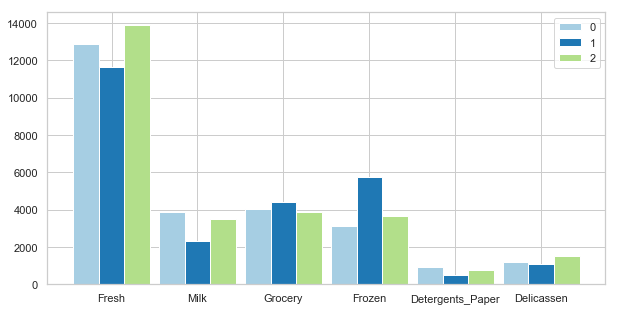

In [0]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = ch_re.columns.values
x_position = np.arange(len(x))

re1 = ch_re.values[0]
re2 = ch_re.values[1]
re3 = ch_re.values[2]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, re1, width=0.3, label=0)
ax.bar(x_position + 0.3, re2, width=0.3, label=1)
ax.bar(x_position + 0.6, re3, width=0.3, label=2)
ax.legend()
ax.set_xticks(x_position + 0.3)
ax.set_xticklabels(x)
plt.show()
# Channel1のやつ

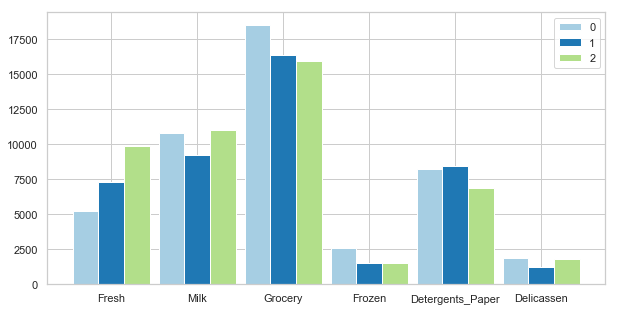

In [0]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Paired')

x = ch_re.columns.values
x_position = np.arange(len(x))

re1 = ch_re.values[3]
re2 = ch_re.values[4]
re3 = ch_re.values[5]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, re1, width=0.3, label=0)
ax.bar(x_position + 0.3, re2, width=0.3, label=1)
ax.bar(x_position + 0.6, re3, width=0.3, label=2)
ax.legend()
ax.set_xticks(x_position + 0.3)
ax.set_xticklabels(x)
plt.show()
# Channel2のやつ

突出した特徴は見られないもののどのChannel・Regionに注力するかなど何かしらの有益な指標にはなりそう
(e.g.
- freshとfrozenは同じ搬送手段(冷凍トラック)なので、シナジーが生まれるから Channel1のRegion1・3の搬出量を増やしていこう
- fresh・Region3の輸送費は高いので、fresh・Region0の搬出量を増やしていこう  
など？  
<br>
他にできそうなアプローチめも  
- Channel≒k=2 の分布なのでk=4に増やして、Channel1・2内でhigh・lowに分けて分析してみる？